[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() 

from sklearn.preprocessing import MinMaxScaler, binarize
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

In [2]:
supSize = 25
titleSize = 20
labelSize = 15
tickSize = 13

---
# Setup Data

## Load & Display Data
[Kaggle Dataset](https://www.kaggle.com/ntnu-testimon/paysim1 "Synthetic Financial Datasets For Fraud Detection")

In [3]:
df = pd.read_csv('data/card.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Check Value Type

In [5]:
print("data types\n{}".format(df.info()))
print("\nnull values:\n{}".format(df.isnull().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
data types
None

null values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## Define Each Feature

### We have 11 initial features:

* **step:** Maps a unit of time in the real world. In this case 1 step is 1 hour of time, 743 is the end of the month
* **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
* **amount:** amount of the transaction in local currency _(may be bigger then the account balance)_
* **nameOrig:** customer who started the transaction _(start with C for customer)_
* **oldbalanceOrg:** initial balance before the transaction _(at least 0)_
* **newbalanceOrig:** customer's balance after the transaction. _(at least 0)_
* **nameDest:** recipient ID of the transaction. _(start with C for customer)_
* **oldbalanceDest:** initial recipient balance before the transaction. _(at least 0)_
* **newbalanceDest:** recipient's balance after the transaction. _(at least 0)_
* **isFraud:** identifies a fraudulent transaction (1) and non fraudulent (0)
* **isFlaggedFraud:** flags illegal attempts to transfer more than 200.000 in a single transaction.

---
# Data Trends

### Transaction Types

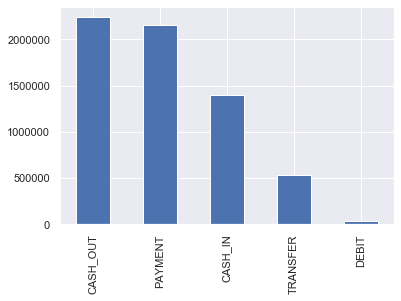

In [6]:
df['type'].value_counts().plot.bar()
plt.show()

In [7]:
precent = df['type'].value_counts(normalize=True)['DEBIT']*100
lines = df[df['type'] == 'DEBIT']['type'].value_counts()['DEBIT']
print("The precent of DEBIT in the Data Set is {:.2f}% ({} lines)".format(precent, lines))

The precent of DEBIT in the Data Set is 0.65% (41432 lines)


### Fraud happens aroud 0.13%

In [8]:
"{:.2f}%".format(df['isFraud'].value_counts(normalize=True)[1]*100)

'0.13%'

### Fraud is only in: TRANSFER, CASH OUT
#### (at about the same amount)

In [9]:
fraud = df[df['isFraud'] == 1]
fraud['type'].value_counts(normalize=True)*100

CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64

### Precentage of Transfer Fraud is about 0.77%

In [10]:
df[df['type'] == 'TRANSFER']['isFraud'].value_counts(normalize=True)[1]*100

0.7687991758442811

### Precentage of Cash Out Fraud is about 0.18%

In [11]:
df[df['type'] == 'CASH_OUT']['isFraud'].value_counts(normalize=True)[1]*100

0.18395530726256984

### If The Transaction Amount Was The Same As The Balance: Its Fraud

In [12]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].unique()

array([1], dtype=int64)

### If the Existing Fraud Detection Flags the Transaction as Fraud, It's Fraud

In [13]:
df[df['isFlaggedFraud'] == 1]['isFraud'].unique()

array([1], dtype=int64)

### All initiates are customers

In [14]:
df['nameOrig'].str[0].unique()

array(['C'], dtype=object)

### Recipients are both customers and merchants

In [15]:
df['nameDest'].str[0].unique()

array(['M', 'C'], dtype=object)

### proper recipients (merchants) do not fraud

In [16]:
df[df['isFraud']==1]['nameDest'].str[0].unique()

array(['C'], dtype=object)

### merchants do not use transaction types with fraud

In [17]:
print(df[df['type']=='TRANSFER']['nameDest'].str[0].unique())
print(df[df['type']=='CASH_OUT']['nameDest'].str[0].unique())

['C']
['C']


### Customers who Commited Fraud also Have Legit Transactions

In [18]:
fraudDoers = df[df['isFraud']==1]['nameDest'].unique()
df[df['nameDest']==fraudDoers[0]].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
6167,6,TRANSFER,109985.65,C570434649,41851.00,0.00,C553264065,0.00,109985.65,0,0
7903,7,CASH_IN,10256.20,C111105514,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,0
16381,8,CASH_OUT,111622.39,C1457214570,2347.00,0.00,C553264065,99729.44,5254.44,0,0
20003,8,CASH_IN,206097.39,C161724858,1991.12,208088.52,C553264065,211351.84,5254.44,0,0


### People who had been scamed had only one transaction in there acount

In [19]:
fraudRecipients = df[df['isFraud']==1]['nameOrig']
print(len(fraudRecipients))
print(len(fraudRecipients.unique()))

8213
8213


### People with only one transaction ...

In [20]:
fraudRecipients = df['nameOrig']
# print(len(fraudRecipients))
# print(len(fraudRecipients.unique()))
fraudRecipientsValues = fraudRecipients.value_counts()
fraudRecipientsValues[9298:]
df[df['isFraud']==1]['nameOrig']

2          C1305486145
3           C840083671
251        C1420196421
252        C2101527076
680         C137533655
              ...     
6362615     C786484425
6362616    C1529008245
6362617    C1162922333
6362618    C1685995037
6362619    C1280323807
Name: nameOrig, Length: 8213, dtype: object

### Though in general there are more Initiates then Recipients, In Fraudulent Transactions it's the other way

In [21]:
print("In Total:")
print("The Number Of Initiates is: {}".format(len(df['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df['nameDest'].unique())))
print("In Fraudulent Transactions:")
print("The Number Of Initiates is: {}".format(len(df[df['isFraud']==1]['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df[df['isFraud']==1]['nameDest'].unique())))

In Total:
The Number Of Initiates is: 6353307
The Number Of Recipients is: 2722362
In Fraudulent Transactions:
The Number Of Initiates is: 8213
The Number Of Recipients is: 8169


### Almost all of the fraudulent transactions where when the amount in the transaction was the same as the account balance

In [22]:
dfFraud = df[df['isFraud']==1][['amount', 'oldbalanceOrg']]
precent = dfFraud[dfFraud['amount']!=dfFraud['oldbalanceOrg']].shape[0]/dfFraud.shape[0]*100
print("The precentage of fraudulent transaction that didn't take the hull balace of the customer is {}%".format(precent))

The precentage of fraudulent transaction that didn't take the hull balace of the customer is 2.1794715694630464%


### The destination account doesn't seem to update according to the transferred amount, probebly to simulate the bank verifying the transaction

In [23]:
amount = df.loc[10]['amount']
delta = df.loc[10]['newbalanceDest'] - df.loc[10]['oldbalanceDest']
print('the amount transferred ({}) doesn\'t match the change in the destination account ({})'.format(amount, delta))

the amount transferred (9644.94) doesn't match the change in the destination account (147137.12)


### check if step helps in finding if fraud exists

isFraud    0
dtype: int64

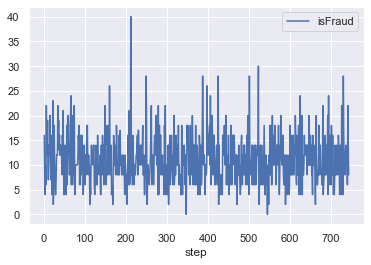

In [24]:
tmp = df[['step', 'isFraud']]
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

change step to times of day 0-23

isFraud    274
dtype: int64

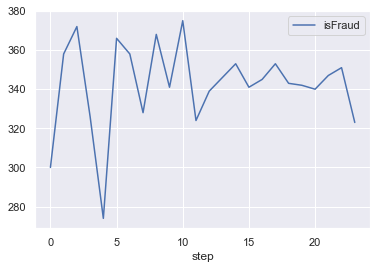

In [25]:
tmp = df[['step', 'isFraud']]%24
# tmp['step'] = tmp['step']%24
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

change step to days

C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


isFraud    220
dtype: int64

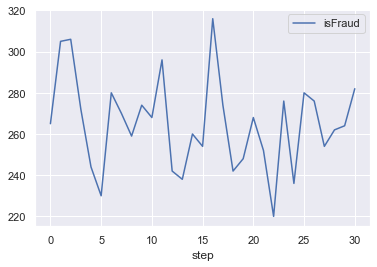

In [26]:
tmp = df[['step', 'isFraud']]
tmp['step'] = tmp['step']//24
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

__step doesn't realy help us__

---
# Predict Fraud

In [27]:
def normalize(df):
    for x in df:
        df[x] = df[x]/df[x].max()

## Clear data from unneeded values for the model

### remove transactions types with no fraud _(to reduce run time)_
We'll take care of that together with the next point

### Change transactions dtype to numeric 
#### note that dummy classifiers makes models slow
```
tmp = pd.get_dummies(data['type'])
data = data.join(tmp)
data = data.drop('type', axis=1)
data.head()
```

In [28]:
d1 = df[df['type']=='TRANSFER']
d2 = df[df['type']=='CASH_OUT']
d1['type'] = 1
d2['type'] = 0
df = pd.concat([d1, d2])
df.info()
df.head()

C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 253.6+ MB


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,1,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,1,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0


### Remove the unneeded columns

In [29]:
df = df.select_dtypes(exclude='object')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(4)
memory usage: 211.4 MB


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,1,181.00,181.00,0.0,0.00,0.00,1,0
19,1,1,215310.30,705.00,0.0,22425.00,0.00,0,0
24,1,1,311685.89,10835.00,0.0,6267.00,2719172.89,0,0
58,1,1,62610.80,79114.00,16503.2,517.00,8383.29,0,0
78,1,1,42712.39,10363.39,0.0,57901.66,24044.18,0,0


In [30]:
df = df.drop('step', axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            int64  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
 7   isFlaggedFraud  int64  
dtypes: float64(5), int64(3)
memory usage: 190.2 MB


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,181.00,181.00,0.0,0.00,0.00,1,0
19,1,215310.30,705.00,0.0,22425.00,0.00,0,0
24,1,311685.89,10835.00,0.0,6267.00,2719172.89,0,0
58,1,62610.80,79114.00,16503.2,517.00,8383.29,0,0
78,1,42712.39,10363.39,0.0,57901.66,24044.18,0,0


In [31]:
normalize(df)
df['type'] = df['type'].astype('int8')
df['isFraud'] = df['isFraud'].astype('int8')
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype('int8')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            int8   
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int8   
 7   isFlaggedFraud  int8   
dtypes: float64(5), int8(3)
memory usage: 134.7 MB


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,0.000002,0.000003,0.000000,0.000000,0.000000,1,0
19,1,0.002329,0.000012,0.000000,0.000063,0.000000,0,0
24,1,0.003372,0.000182,0.000000,0.000018,0.007634,0,0
58,1,0.000677,0.001328,0.000333,0.000001,0.000024,0,0
78,1,0.000462,0.000174,0.000000,0.000163,0.000068,0,0


In [32]:
X=df.drop('isFraud', axis=1)
y=df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train
We'll be trying to achieve high sensitivity in our models

In [33]:
def evaluate(true, pred):
    model_accuracy = roc_auc_score(true, pred)
    null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
    print("Null AUC Score: {:.5f}".format(null_accuracy))
    print("Model AUC Score: {:.5f}".format(model_accuracy))

    if null_accuracy >= model_accuracy:
        print("The model isn't effective")
#         return
    else:
        print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))

In [34]:
def optimalModel(model, y_test, X_test, scoring='roc_auc', average='macro', speed='normal'):
    if speed == 'normal':
        s = 1
    elif speed == 'quick':
        s = 3
    y_pred = model.predict_proba(X_test)[:, 1]
    if scoring == 'roc_auc':  # TODO: cut run time
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        scores = []
        for x in range(0, len(thresholds), s):
            y_pred_class = binarize([y_pred], thresholds[x])[0]
            scores.append(roc_auc_score(y_test, y_pred_class, average))
        scores = np.array(scores)
        index = np.argmax(scores)
    if scoring == 'average_precision':
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        scores = []
        for x in thresholds:
            y_pred_class = binarize([y_pred], x)[0]
            scores.append(average_precision_score(y_test, y_pred_class))
        scores = np.array(scores)
        index = np.argmax(scores)        
    if scoring == 'sensitivity':
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        index = np.argmax(recall)
    if scoring == 'specificity':
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        index = np.argmax(precision)
    y_pred_class = binarize([y_pred], thresholds[index])[0]
    evaluate(y_test, y_pred_class)
    return thresholds[index]

### Naive Bayes

In [35]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
predictions = mnb.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.50030
The model is better then a 'dumb' model
confusion_matrix:
 [[552404      0]
 [  1677      1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       1.00      0.00      0.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      0.50      0.50    554082
weighted avg       1.00      1.00      1.00    554082



In [36]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.67267
The model is better then a 'dumb' model
confusion_matrix:
 [[547622   4782]
 [  1084    594]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552404
           1       0.11      0.35      0.17      1678

    accuracy                           0.99    554082
   macro avg       0.55      0.67      0.58    554082
weighted avg       1.00      0.99      0.99    554082



In [37]:
optimalModel(gnb, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.82550
The model is better then a 'dumb' model
confusion_matrix:
 [[471545  80859]
 [   340   1338]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    552404
           1       0.02      0.80      0.03      1678

    accuracy                           0.85    554082
   macro avg       0.51      0.83      0.48    554082
weighted avg       1.00      0.85      0.92    554082



2.7637432999243908e-09

### Decision Tree

In [38]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.94204
The model is better then a 'dumb' model
confusion_matrix:
 [[552239    165]
 [   194   1484]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.90      0.88      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



In [39]:
optimalModel(dtc, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.94204
The model is better then a 'dumb' model
confusion_matrix:
 [[552239    165]
 [   194   1484]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.90      0.88      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



0.00043886887757214427

In [40]:
dtcf = DecisionTreeClassifier(max_features=7)
dtcf.fit(X_train, y_train)
predictions = dtcf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.94234
The model is better then a 'dumb' model
confusion_matrix:
 [[552238    166]
 [   193   1485]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.90      0.88      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



In [41]:
optimalModel(dtcf, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.94234
The model is better then a 'dumb' model
confusion_matrix:
 [[552238    166]
 [   193   1485]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.90      0.88      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



0.00043886887757214427

### Adaboost

In [42]:
ab = AdaBoostClassifier(random_state=0, n_estimators=10)
ab.fit(X_train,y_train)
optimalModel(ab, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.89786
The model is better then a 'dumb' model
confusion_matrix:
 [[490261  62143]
 [   154   1524]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552404
           1       0.02      0.91      0.05      1678

    accuracy                           0.89    554082
   macro avg       0.51      0.90      0.49    554082
weighted avg       1.00      0.89      0.94    554082



0.34860613139905994

In [43]:
ab = AdaBoostClassifier(random_state=0, n_estimators=20, learning_rate=0.5)
ab.fit(X_train,y_train)
optimalModel(ab, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.89497
The model is better then a 'dumb' model
confusion_matrix:
 [[489369  63035]
 [   161   1517]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552404
           1       0.02      0.90      0.05      1678

    accuracy                           0.89    554082
   macro avg       0.51      0.89      0.49    554082
weighted avg       1.00      0.89      0.94    554082



0.347143060915202

In [44]:
ab = AdaBoostClassifier(random_state=0, n_estimators=30, learning_rate=0.5)
ab.fit(X_train,y_train)
optimalModel(ab, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.89772
The model is better then a 'dumb' model
confusion_matrix:
 [[492739  59665]
 [   162   1516]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552404
           1       0.02      0.90      0.05      1678

    accuracy                           0.89    554082
   macro avg       0.51      0.90      0.50    554082
weighted avg       1.00      0.89      0.94    554082



0.40021990645157923

In [45]:
abt = AdaBoostClassifier(base_estimator=dtcf, n_estimators=10, random_state=0)
abt.fit(X_train,y_train)
optimalModel(ab, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.89772
The model is better then a 'dumb' model
confusion_matrix:
 [[492739  59665]
 [   162   1516]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552404
           1       0.02      0.90      0.05      1678

    accuracy                           0.89    554082
   macro avg       0.51      0.90      0.50    554082
weighted avg       1.00      0.89      0.94    554082



0.40021990645157923

### Logistic Regression

In [46]:
lr2 = LogisticRegression(random_state=0, solver='lbfgs', penalty='l2')
lr2.fit(X_train,y_train)
predictions = lr2.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.54708
The model is better then a 'dumb' model
confusion_matrix:
 [[552400      4]
 [  1520    158]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.98      0.09      0.17      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.55      0.59    554082
weighted avg       1.00      1.00      1.00    554082



In [47]:
optimalModel(lr2, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.80976
The model is better then a 'dumb' model
confusion_matrix:
 [[414651 137753]
 [   220   1458]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86    552404
           1       0.01      0.87      0.02      1678

    accuracy                           0.75    554082
   macro avg       0.50      0.81      0.44    554082
weighted avg       1.00      0.75      0.85    554082



0.0019748543738890172

In [48]:
lr1 = LogisticRegression(random_state=0, solver='liblinear', penalty='l1')
lr1.fit(X_train,y_train)
predictions = lr1.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.70462
The model is better then a 'dumb' model
confusion_matrix:
 [[552306     98]
 [   991    687]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.88      0.41      0.56      1678

    accuracy                           1.00    554082
   macro avg       0.94      0.70      0.78    554082
weighted avg       1.00      1.00      1.00    554082



In [49]:
optimalModel(lr1, y_test, X_test)

Null AUC Score: 0.50000
Model AUC Score: 0.91958
The model is better then a 'dumb' model
confusion_matrix:
 [[503387  49017]
 [   121   1557]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    552404
           1       0.03      0.93      0.06      1678

    accuracy                           0.91    554082
   macro avg       0.52      0.92      0.51    554082
weighted avg       1.00      0.91      0.95    554082



0.003096957648272876

### Random forest

In [50]:
rf = RandomForestClassifier(random_state=0, max_depth=None, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [51]:
rff = RandomForestClassifier(random_state=0, max_depth=None, n_estimators=10, bootstrap=False)
rff.fit(X_train, y_train)
predictions = rff.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88168
The model is better then a 'dumb' model
confusion_matrix:
 [[552381     23]
 [   397   1281]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.98      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [52]:
parm_grid = dict(n_estimators=[10, 20], min_samples_leaf=[.5, 1], max_features=[None, 'sqrt'], bootstrap=[False, True])
grid = RandomizedSearchCV(rf, parm_grid, cv=3, scoring='roc_auc', n_iter=2, random_state=0)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'n_estimators': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}


### SVC

In [53]:
svc = SVC(random_state=0, max_iter=500)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
evaluate(y_test, predictions)

C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Null AUC Score: 0.50000
Model AUC Score: 0.66327
The model is better then a 'dumb' model
confusion_matrix:
 [[447693 104711]
 [   812    866]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    552404
           1       0.01      0.52      0.02      1678

    accuracy                           0.81    554082
   macro avg       0.50      0.66      0.46    554082
weighted avg       1.00      0.81      0.89    554082



In [54]:
lsvc = LinearSVC(random_state=0, tol=1e-4)
lsvc.fit(X_train, y_train)
predictions = lsvc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.60786
The model is better then a 'dumb' model
confusion_matrix:
 [[552399      5]
 [  1316    362]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.99      0.22      0.35      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.61      0.68    554082
weighted avg       1.00      1.00      1.00    554082



## Plot AUC score of the models

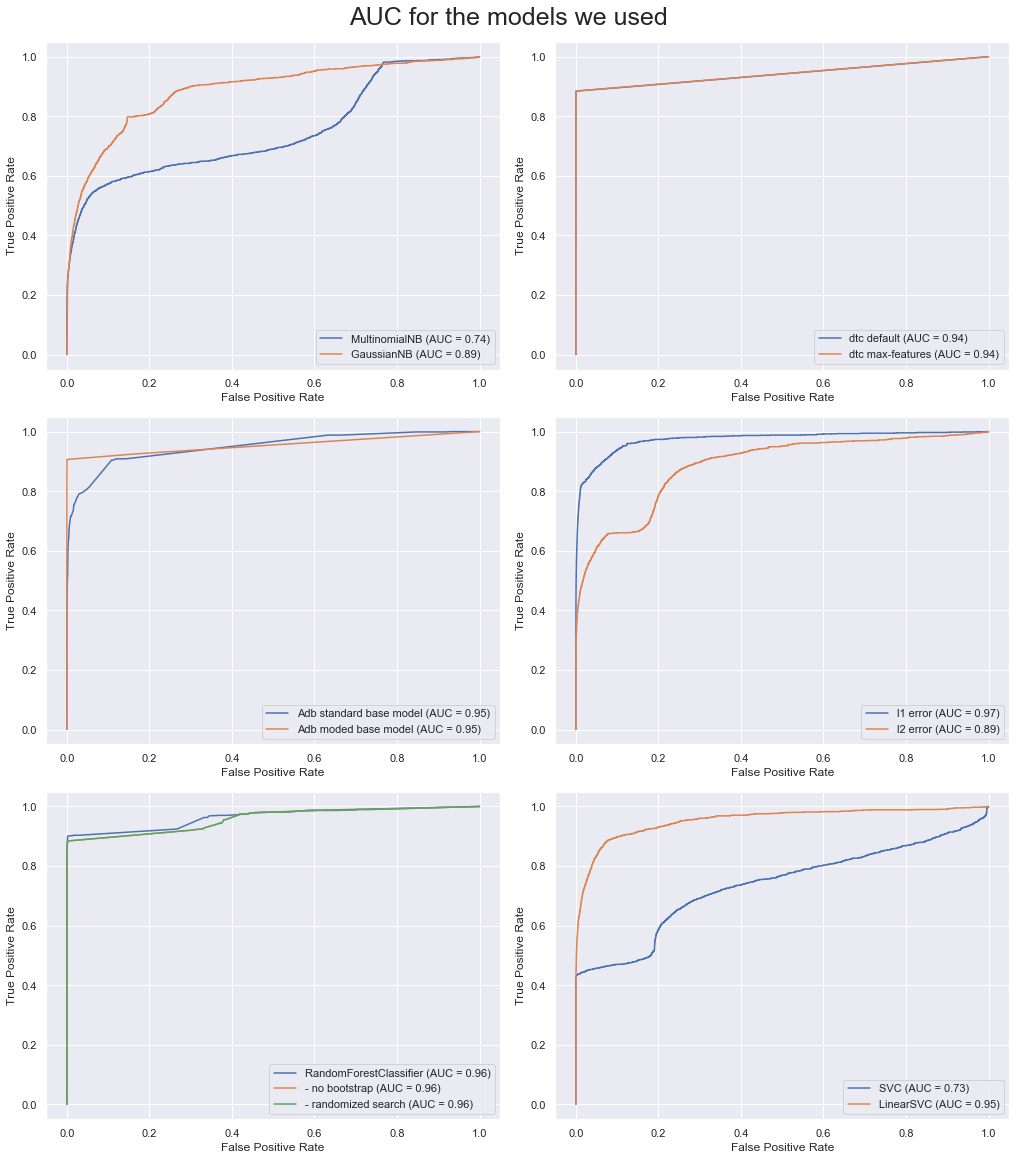

In [56]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 16), constrained_layout=True)

plot_roc_curve(mnb, X_test, y_test, ax=ax1)
plot_roc_curve(gnb, X_test, y_test, ax=ax1)

plot_roc_curve(dtc, X_test, y_test, ax=ax2, name='dtc default')
plot_roc_curve(dtcf, X_test, y_test, ax=ax2, name='dtc max-features')

plot_roc_curve(ab, X_test, y_test, ax=ax3, name='Adb standard base model')
plot_roc_curve(abt, X_test, y_test, ax=ax3, name='Adb moded base model')

plot_roc_curve(lr1, X_test, y_test, ax=ax4, name='l1 error')
plot_roc_curve(lr2, X_test, y_test, ax=ax4, name='l2 error')

plot_roc_curve(rf, X_test, y_test, ax=ax5)
plot_roc_curve(rff, X_test, y_test, ax=ax5, name='- no bootstrap')
plot_roc_curve(grid, X_test, y_test, ax=ax5, name='- randomized search')

plot_roc_curve(svc, X_test, y_test, ax=ax6)
plot_roc_curve(lsvc, X_test, y_test, ax=ax6)

fig.suptitle ('AUC for the models we used', fontsize=supSize)
# ax.set_title('AUC for the models we used', fontsize=titleSize)
# ax.set_xlabel('Top Most Common Apps', fontsize=labelSize)
# ax.set_ylabel('App Size In Mb', fontsize=labelSize)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=tickSize)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=tickSize)

plt.show()

__lets look at the random forest in a bigger view__

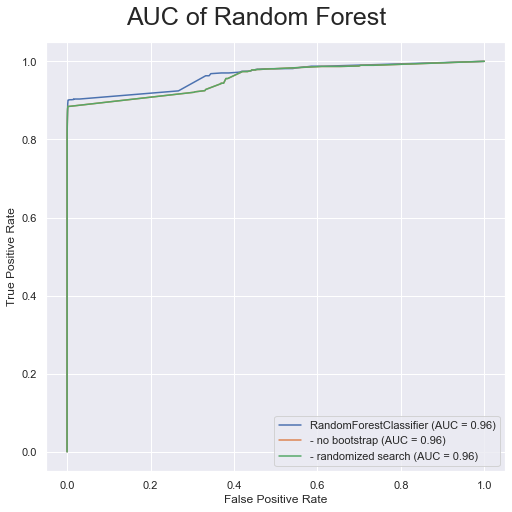

In [59]:
fig, ax= plt.subplots(figsize=(7, 7), constrained_layout=True)

fig.suptitle ('AUC of Random Forest', fontsize=supSize)

plot_roc_curve(rf, X_test, y_test, ax=ax)
plot_roc_curve(rff, X_test, y_test, ax=ax, name='- no bootstrap')
plot_roc_curve(grid, X_test, y_test, ax=ax, name='- randomized search')

plt.show()

__the best model is the standart Random forest__

### Evaluate the model

In [60]:
optimalModel(rf, y_test, X_test, 'roc_auc')

Null AUC Score: 0.50000
Model AUC Score: 0.94912
The model is better then a 'dumb' model
confusion_matrix:
 [[550834   1570]
 [   166   1512]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.49      0.90      0.64      1678

    accuracy                           1.00    554082
   macro avg       0.75      0.95      0.82    554082
weighted avg       1.00      1.00      1.00    554082



0.026295980072963566

In [61]:
optimalModel(rf, y_test, X_test, 'average_precision')

Null AUC Score: 0.50000
Model AUC Score: 0.88674
The model is better then a 'dumb' model
confusion_matrix:
 [[552376     28]
 [   380   1298]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.98      0.77      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.89      0.93    554082
weighted avg       1.00      1.00      1.00    554082



0.40060281116299173

In [62]:
optimalModel(rf, y_test, X_test, 'sensitivity')

Null AUC Score: 0.50000
Model AUC Score: 0.68665
The model is better then a 'dumb' model
confusion_matrix:
 [[213127 339277]
 [    21   1657]]
              precision    recall  f1-score   support

           0       1.00      0.39      0.56    552404
           1       0.00      0.99      0.01      1678

    accuracy                           0.39    554082
   macro avg       0.50      0.69      0.28    554082
weighted avg       1.00      0.39      0.56    554082



0.0

In [63]:
optimalModel(rf, y_test, X_test, 'specificity')

Null AUC Score: 0.50000
Model AUC Score: 0.50000
The model isn't effective
confusion_matrix:
 [[552404      0]
 [  1678      0]]


C:\Users\mthee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.00      0.00      0.00      1678

    accuracy                           1.00    554082
   macro avg       0.50      0.50      0.50    554082
weighted avg       0.99      1.00      1.00    554082



1.0

### Improve existing fraud detection

In [64]:
df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'].value_counts()

0    16
Name: isFlaggedFraud, dtype: int64

In [65]:
# df['myFlaggedFraud'] = df['isFlaggedFraud']
# size = len(df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'])
d1 = df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud']
d2 = df[df['amount']!=df['oldbalanceOrg']]['isFlaggedFraud']
d1 = d1.replace(0, 1)
df['isFlaggedFraud'] = pd.concat([d1, d2])

In [66]:
df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'].value_counts()

1    16
Name: isFlaggedFraud, dtype: int64

### Run our best model again with improved fraud detection

In [67]:
X=df.drop('isFraud', axis=1)
y=df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [68]:
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88139
The model is better then a 'dumb' model
confusion_matrix:
 [[552388     16]
 [   398   1280]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [69]:
optimalModel(rf, y_test, X_test, 'roc_auc')

Null AUC Score: 0.50000
Model AUC Score: 0.94935
The model is better then a 'dumb' model
confusion_matrix:
 [[551096   1308]
 [   166   1512]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.54      0.90      0.67      1678

    accuracy                           1.00    554082
   macro avg       0.77      0.95      0.84    554082
weighted avg       1.00      1.00      1.00    554082



0.02946730172263339

In [70]:
optimalModel(rf, y_test, X_test, 'average_precision')

Null AUC Score: 0.50000
Model AUC Score: 0.89151
The model is better then a 'dumb' model
confusion_matrix:
 [[552372     32]
 [   364   1314]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552404
           1       0.98      0.78      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.89      0.93    554082
weighted avg       1.00      1.00      1.00    554082



0.4